# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator


from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline


'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep =';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

   
###  General Demographics Dataset 

<b>Dataset Description:</b> Udacity_AZDIAS_Subset.csv: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

#Genereal demographic -sample data
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
#General demographic - info summary
azdias.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 85 entries, AGER_TYP to RELAT_AB
dtypes: float64(49), int64(32), object(4)
memory usage: 578.0+ MB


In [6]:
#General demographic row and column count
print(azdias.shape)

(891221, 85)


   
###  Feature Summary Dataset 

<b>Dataset Description:</b> AZDIAS_Feature_Summary.csv: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

In [7]:
#Feature summary - sample data
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
#Feature summary - dataset info
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
#Feature summary - row and column count
print('Columns/Rows: {}'.format(feat_info.shape))

Columns/Rows: (85, 4)


   
### Data Dictionary 

<b>Data Dictionary:</b> Data_Dictionary.md: Detailed information file about the features in the provided datasets.

In [10]:
#loading and printing the data dictionary
data_dict=open('Data_Dictionary.md').read()
print(data_dict)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
#Printing the count of naturally null values in the demographics dataset
n_azdias_null = azdias.isnull().sum().sum()
print('Missing values in the dataset = {:,}'.format(n_azdias_null))

Missing values in the dataset = 4,896,838


In [12]:
#Identify missing or unknown data values and convert them to NaNs.

#create function to iterate for each attribute in feat_info and identify missing/unknown value codes.
for i in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[i]['missing_or_unknown']
    #stripping the brackets and comma from the identified missing or unknown values
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    #adding comma seperator between values
    missing_or_unknown = missing_or_unknown.split(sep = ',')
    #converting values into integers and adding them to the missing/unk list (if they are not X, XX or empty)
    missing_or_unknown = [int(value) if (value!= 'X' and value !='XX' and value!='') 
    else value for value in missing_or_unknown]
    #replacing missing or unknown values in azdias with NaN
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)

In [13]:
#Number of values missing after conversion
#recalculating n_azdias_null 
n_azdias_null = azdias.isnull().sum().sum()
print('Number of values missing after conversion:{:,}'.format(n_azdias_null))

Number of values missing after conversion:8,373,929


<b>Note:</b> The number of missing values increased by more than 50%. The reason is because we replaced all of the missing or unknown value codes with NaN.  

In [14]:
#printing unique values of all columns in azdias for visual inspection
for i in azdias.columns:
    if azdias[i].dtype in [np.int64, np.float64]:
        print(i)
        print(np.unique(azdias[i]))

AGER_TYP
[  1.   2.   3. ...,  nan  nan  nan]
ALTERSKATEGORIE_GROB
[  1.   2.   3. ...,  nan  nan  nan]
ANREDE_KZ
[1 2]
CJT_GESAMTTYP
[  1.   2.   3. ...,  nan  nan  nan]
FINANZ_MINIMALIST
[1 2 3 4 5]
FINANZ_SPARER
[1 2 3 4 5]
FINANZ_VORSORGER
[1 2 3 4 5]
FINANZ_ANLEGER
[1 2 3 4 5]
FINANZ_UNAUFFAELLIGER
[1 2 3 4 5]
FINANZ_HAUSBAUER
[1 2 3 4 5]
FINANZTYP
[1 2 3 4 5 6]
GEBURTSJAHR
[ 1900.  1902.  1904. ...,    nan    nan    nan]
GFK_URLAUBERTYP
[  1.   2.   3. ...,  nan  nan  nan]
GREEN_AVANTGARDE
[0 1]
HEALTH_TYP
[  1.   2.   3. ...,  nan  nan  nan]
LP_LEBENSPHASE_FEIN
[  1.   2.   3. ...,  nan  nan  nan]
LP_LEBENSPHASE_GROB
[  1.   2.   3. ...,  nan  nan  nan]
LP_FAMILIE_FEIN
[  1.   2.   3. ...,  nan  nan  nan]
LP_FAMILIE_GROB
[  1.   2.   3. ...,  nan  nan  nan]
LP_STATUS_FEIN
[  1.   2.   3. ...,  nan  nan  nan]
LP_STATUS_GROB
[  1.   2.   3. ...,  nan  nan  nan]
NATIONALITAET_KZ
[  1.   2.   3. ...,  nan  nan  nan]
PRAEGENDE_JUGENDJAHRE
[  1.   2.   3. ...,  nan  nan  nan]
RETOURTY

In [15]:
#printing unique values of all columns in azdias for visual inspection
for i in azdias.columns:
    if azdias[i].dtype in [np.int64, np.float64]:
        print(i)
        print(np.unique(azdias[i]))

AGER_TYP
[  1.   2.   3. ...,  nan  nan  nan]
ALTERSKATEGORIE_GROB
[  1.   2.   3. ...,  nan  nan  nan]
ANREDE_KZ
[1 2]
CJT_GESAMTTYP
[  1.   2.   3. ...,  nan  nan  nan]
FINANZ_MINIMALIST
[1 2 3 4 5]
FINANZ_SPARER
[1 2 3 4 5]
FINANZ_VORSORGER
[1 2 3 4 5]
FINANZ_ANLEGER
[1 2 3 4 5]
FINANZ_UNAUFFAELLIGER
[1 2 3 4 5]
FINANZ_HAUSBAUER
[1 2 3 4 5]
FINANZTYP
[1 2 3 4 5 6]
GEBURTSJAHR
[ 1900.  1902.  1904. ...,    nan    nan    nan]
GFK_URLAUBERTYP
[  1.   2.   3. ...,  nan  nan  nan]
GREEN_AVANTGARDE
[0 1]
HEALTH_TYP
[  1.   2.   3. ...,  nan  nan  nan]
LP_LEBENSPHASE_FEIN
[  1.   2.   3. ...,  nan  nan  nan]
LP_LEBENSPHASE_GROB
[  1.   2.   3. ...,  nan  nan  nan]
LP_FAMILIE_FEIN
[  1.   2.   3. ...,  nan  nan  nan]
LP_FAMILIE_GROB
[  1.   2.   3. ...,  nan  nan  nan]
LP_STATUS_FEIN
[  1.   2.   3. ...,  nan  nan  nan]
LP_STATUS_GROB
[  1.   2.   3. ...,  nan  nan  nan]
NATIONALITAET_KZ
[  1.   2.   3. ...,  nan  nan  nan]
PRAEGENDE_JUGENDJAHRE
[  1.   2.   3. ...,  nan  nan  nan]
RETOURTY

In [16]:
#printing first few rows of azdias for visual inspection
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#create dataframe to store and document columns data with missing values
missing_data = pd.DataFrame(azdias.shape[0] - azdias.count())
missing_data.columns = ['missing_data_count']
missing_list = pd.DataFrame(missing_data[missing_data['missing_data_count']>0])

#print list of columns with missing data counts
print('List of columns with missing data:\n\n',missing_list.sort_index())

List of columns with missing data:

                        missing_data_count
AGER_TYP                           685843
ALTERSKATEGORIE_GROB                 2881
ALTER_HH                           310267
ANZ_HAUSHALTE_AKTIV                 99611
ANZ_HH_TITEL                        97008
ANZ_PERSONEN                        73499
ANZ_TITEL                           73499
ARBEIT                              97375
BALLRAUM                            93740
CAMEO_DEUG_2015                     99352
CAMEO_DEU_2015                      99352
CAMEO_INTL_2015                     99352
CJT_GESAMTTYP                        4854
EWDICHTE                            93740
GEBAEUDETYP                         93148
GEBAEUDETYP_RASTER                  93155
GEBURTSJAHR                        392318
GFK_URLAUBERTYP                      4854
HEALTH_TYP                         111196
HH_EINKOMMEN_SCORE                  18348
INNENSTADT                          93740
KBA05_ANTG1                        1333

In [18]:
#summarizing columns with/with out missing data
n_columns = (len(azdias.columns)) #total columns in azdias
print('Total number of columns: {} (100%)\n-------------------------------------------------'.format(n_columns))
n_missing_data = missing_list.shape[0] #columns missing data
print('Number of columns missing data: {} ({:.2f}%)\n-------------------------------------------------'.format(n_missing_data, n_missing_data / n_columns * 100))
n_not_missing_data = n_columns - n_missing_data #columns not missing data
print('Number of columns not missing data: {} ({:.2f}%)\n-------------------------------------------------'.format(n_not_missing_data, n_not_missing_data / n_columns * 100))


Total number of columns: 85 (100%)
-------------------------------------------------
Number of columns missing data: 61 (71.76%)
-------------------------------------------------
Number of columns not missing data: 24 (28.24%)
-------------------------------------------------


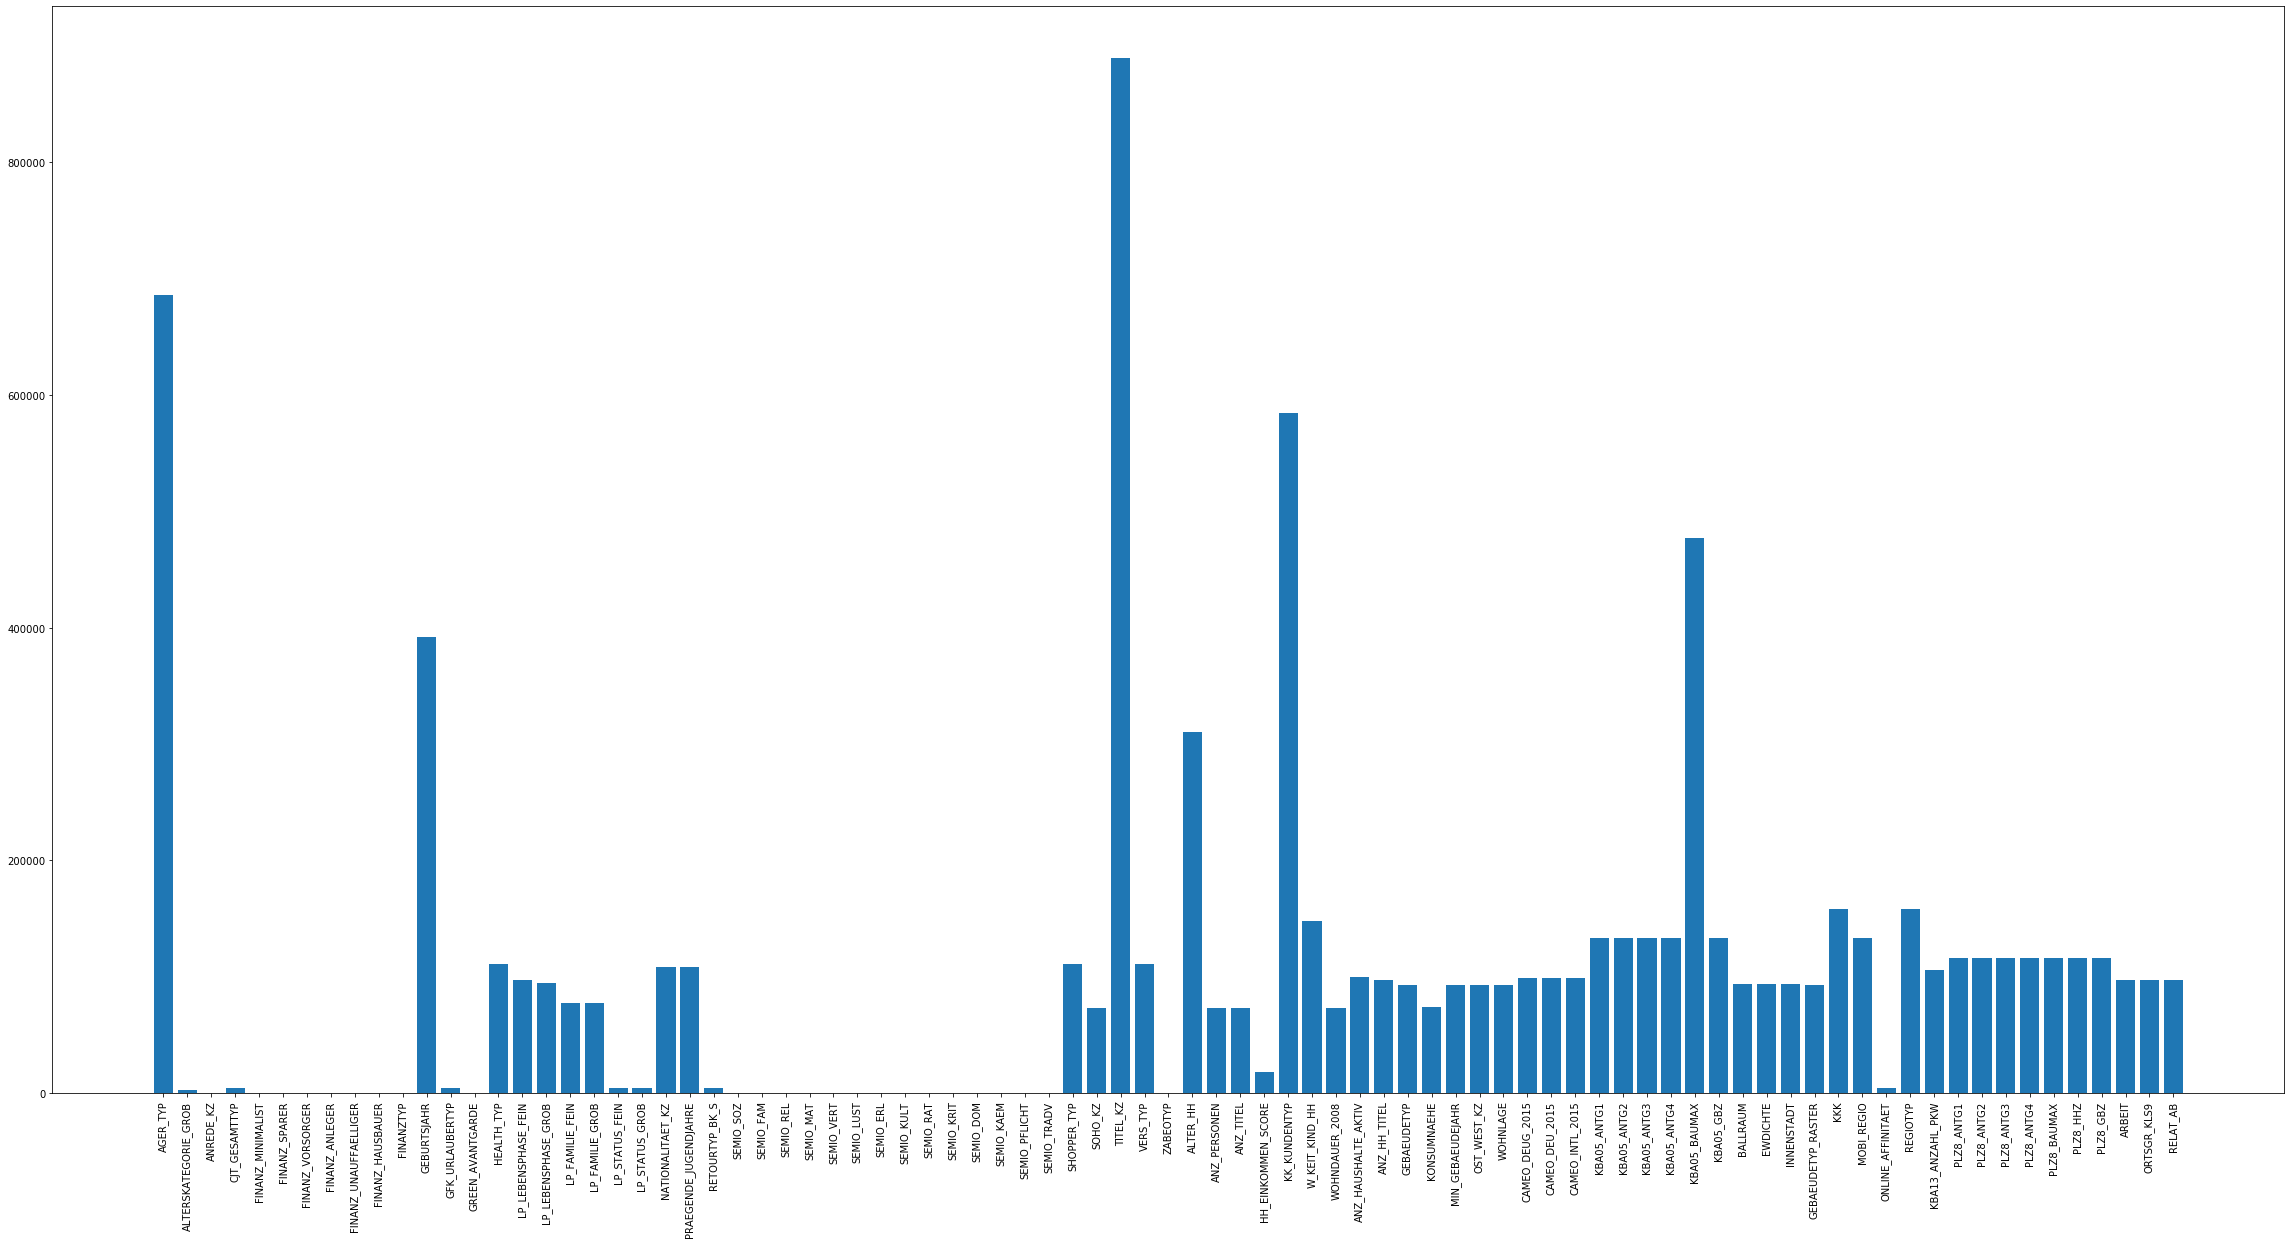

In [19]:
# Investigate patterns in the amount of missing data in each column.

#creating a function to plot the distribution of missing value counts
def missing_data_distribution(data):
    fig, ax = plt.subplots(figsize=(40,20))
    ax.bar(data.columns,data.isna().sum())
    plt.xticks(rotation=90);

missing_data_distribution(azdias)

In [20]:
#adding percent of missing values column to missing_data
missing_list['percent_missing_values'] = ((missing_list['missing_data_count'] / n_azdias_null) * 100).round(2)

#calculating the mean percent of missing values for each column
avg_percent_missing = np.mean(missing_list['percent_missing_values'])

#printing the columns that have a larger than average percent of missing values
print('Columns with a larger than average count of missing values:\n\n',missing_list[missing_list['percent_missing_values'] > avg_percent_missing ].sort_values(['percent_missing_values'], ascending = False)) 

Columns with a larger than average count of missing values:

                 missing_data_count  percent_missing_values
TITEL_KZ                    889061                   10.62
AGER_TYP                    685843                    8.19
KK_KUNDENTYP                584612                    6.98
KBA05_BAUMAX                476524                    5.69
GEBURTSJAHR                 392318                    4.68
ALTER_HH                    310267                    3.71
KKK                         158064                    1.89
REGIOTYP                    158064                    1.89
W_KEIT_KIND_HH              147988                    1.77


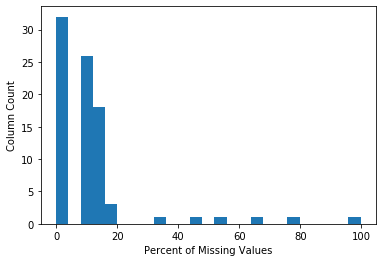

In [21]:
#plotting the percent of missing values by number of columns
pct_miss = (azdias.isnull().sum()/len(azdias))*100
plt.hist(pct_miss, bins = 25)
plt.xlabel('Percent of Missing Values')
plt.ylabel('Column Count')
plt.show()

<b>Note:</b> This graph shows that the majority of columns have at most 20 missing values, while a few of them contain a much higher amount of missing values.

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#creating a list of outlier columns
drop_columns = missing_list[missing_list['percent_missing_values'] > 3 ].index.tolist()
print('The following columns will be dropped:\n\n{}'.format(drop_columns))

#creating independent list of dropped columns for later use
dropped_feature_list = []
for feature in drop_columns:
    dropped_feature_list.append(feature)
dropped_feature_list    

The following columns will be dropped:

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [23]:
#creating dataframe to retain original data
azdias_full_data = pd.DataFrame(azdias)
#dropping outlier columns from azdias
azdias = azdias.drop(drop_columns,axis = 1)

In [24]:
#confirming that the column count is 6 less than the original 85 column count
print('Original dataset contains {} columns.\n\
Outlier columns dropped: {}\n\
Updated dataset contains {} columns.'.format(azdias_full_data.shape[1],len(dropped_feature_list),azdias.shape[1]))

Original dataset contains 85 columns.
Outlier columns dropped: 6
Updated dataset contains 79 columns.


#### Discussion 1.1.2: Assess Missing Data in Each Column

The first distribution chart shows that a small subset of columns stood out with a significantly larger number of missing values compared to the rest. These columns were our outliers and represented a distinct pattern in the data.
 
To gain a clearer understanding, I added a new column that calculated the percentage of missing values per column. By printing a list of averages and sorting it in descending order, I could easily identify and match these columns to the outliers observed in the distribution chart. As expected, the list showed 6 columns with a highter than average amount of missing values.

The histogram also shows that the majority of the columns fell between 0 and 20, with 6 columns standing out on their own.



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

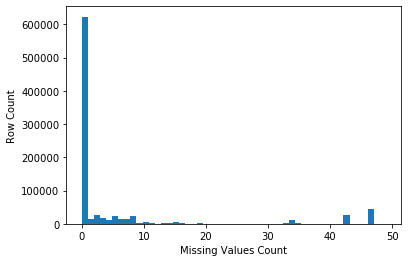

In [25]:
#How much data is misssing in each row of the dataset?

#Plotting distribution of missing data in rows
n_missing_row = azdias.isnull().sum(axis = 1)
plt.hist(n_missing_row, bins = 50)
plt.ylabel('Row Count')
plt.xlabel('Missing Values Count')
plt.show()


In [26]:

# Write code to divide the data into two subsets based on the number of missing
 #values in each row.

#analyzing row counts 
total_row_count = azdias.shape[0] 
n_rows_missing_data =azdias[azdias.isnull().sum(axis = 1) >0]
n_rows_missing_0 = azdias[azdias.isnull().sum(axis=1) <= 0]

#splitting rows into 2 subsets
rows_missing_0_20 = azdias[azdias.isnull().sum(axis = 1) <= 20]
rows_missing_20_plus = azdias[azdias.isnull().sum(axis = 1) >20]
print('Total row count : {:,} (100%)\n-------------------------------------------------'.format(total_row_count))
print('Rows missing 0 : {:,} ({:.2f}% of total)\n-------------------------------------------------'.format(n_rows_missing_0.shape[0], (n_rows_missing_0.shape[0] / total_row_count * 100)))
print('Rows missing data : {:,} ({:.2f}% of total)\n-------------------------------------------------'.format(n_rows_missing_data.shape[0], (n_rows_missing_data.shape[0] / total_row_count * 100)))
print('Summary of new subsets:\nRows missing 0 to 20 values : {:,} ({:.2f}% of total row count.)'.format(rows_missing_0_20.shape[0], (rows_missing_0_20.shape[0] / total_row_count * 100)))
print('Rows missing more than 20 values : {:,} ({:.2f}% of total row count.)'.format(rows_missing_20_plus.shape[0], (rows_missing_20_plus.shape[0] /total_row_count * 100)))

Total row count : 891,221 (100%)
-------------------------------------------------
Rows missing 0 : 623,209 (69.93% of total)
-------------------------------------------------
Rows missing data : 268,012 (30.07% of total)
-------------------------------------------------
Summary of new subsets:
Rows missing 0 to 20 values : 797,426 (89.48% of total row count.)
Rows missing more than 20 values : 93,795 (10.52% of total row count.)


In [27]:
#creating dataframe to include only rows with 20 or less missing values
#storing the full dataset
azdias_full_data = pd.DataFrame(azdias)
#trimming azdias to only include rows missing 20 or less values
azdias= pd.DataFrame(rows_missing_0_20)
print('Total original row count : {:,}\n-------------------------------------------------'.format(total_row_count))
print('Rows removed (>20 missing values):{:,}'.format(azdias.shape[0]))
print('Updated row count: {:,}'.format(azdias.shape[0]))


Total original row count : 891,221
-------------------------------------------------
Rows removed (>20 missing values):797,426
Updated row count: 797,426


The plot, as well as the analysis above confirm that 89.48% of the rows are missing little to no values, while the remaining 10.52% are missing more than 20 values per row. 

In [28]:
#create dataframe to store and document columns with zero missing values
no_missing_data = pd.DataFrame(azdias.shape[0] - azdias.count())
no_missing_data.columns = ['missing_data_count']

#creating list of columns with zero missing values
no_missing_list = no_missing_data[no_missing_data['missing_data_count']<=0].index.tolist()
compare_list = no_missing_list[:6]

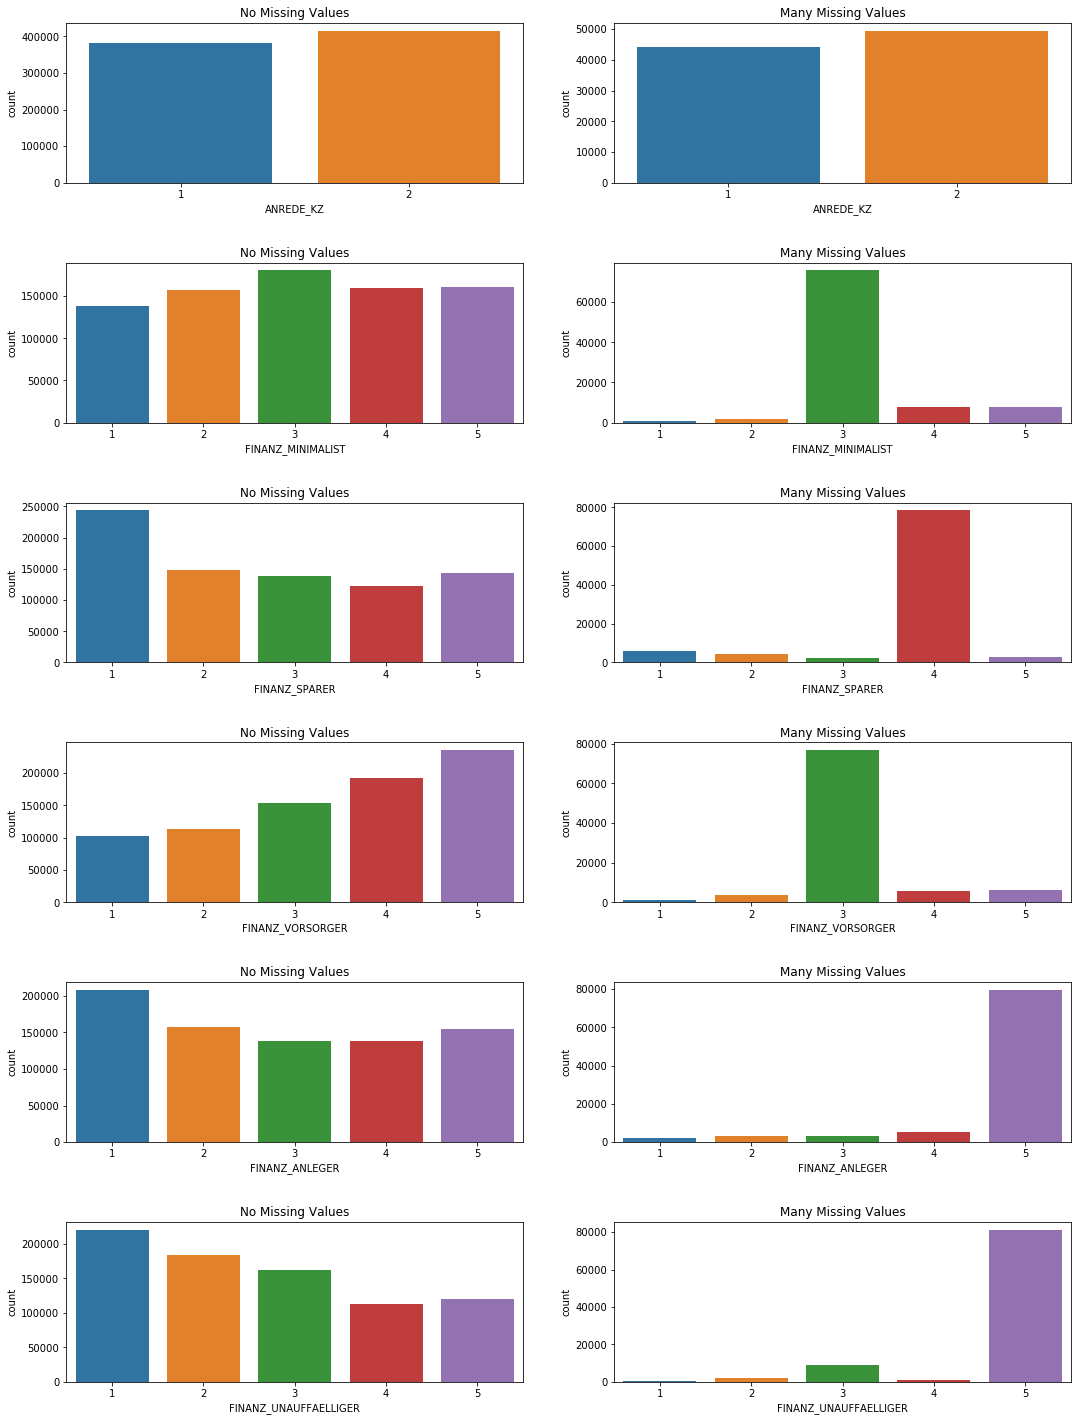

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

figure, axs = plt.subplots(nrows=len(compare_list), ncols=2, figsize = (18,25))
figure.subplots_adjust(hspace = .5, wspace=.2)
for i in range(len(compare_list)):
    sns.countplot(rows_missing_0_20[compare_list[i]], ax=axs[i][0])
    axs[i][0].set_title('No Missing Values')
    sns.countplot(rows_missing_20_plus[compare_list[i]], ax=axs[i][1])
    axs[i][1].set_title('Many Missing Values')


#### Discussion 1.1.3: Assess Missing Data in Each Row

The histogram showed that approximately 10.52% of the rows contained 20 or more missing values, and are seperated on the graph from the majority of the data with 20 or less missing values in each row.  When comparing the side by side plots, it's very obvious that the data quality and distribution were not the same. 

This clearly shows why cleaning the data and dealing with outliers matters.  IF we want to do clustering or make predictions based on this data, including outlier columns with many missing values would likely result in an unreliable and incorrect prediction.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?
feat_info = feat_info[feat_info.attribute.isin(list(azdias.columns.values))]
feat_info['type'].value_counts(),feat_info.shape[0]

(ordinal        49
 categorical    18
 numeric         6
 mixed           6
 Name: type, dtype: int64, 79)

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#identifying categorical features:
categorical = feat_info[feat_info["type"]=="categorical"]["attribute"]
categorical = [feature for feature in categorical if feature in azdias.columns]
print('Categorical features: {}\n\n{}'.format(len(categorical),categorical))

Categorical features: 18

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [32]:
#Identify the binary and multi-level features and append them to lists
binary_features = []
multi_level_features=[]
for feature in categorical:
    if (len(rows_missing_0_20[feature].unique()) ==
        2):
        binary_features.append(feature)
    elif (len(rows_missing_0_20[feature].unique()) > 2):
        multi_level_features.append(feature)

print("Binary Features: ({})\n\n{}".format(len(binary_features),binary_features))
print("\n\nMulti-Level Features: ({})\n\n{}".format(len(multi_level_features),multi_level_features))

Binary Features: (4)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']


Multi-Level Features: (14)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [33]:
#view unique values for binary features
for feature in binary_features:
    print('{} {}'.format(feature, azdias[feature].unique()))

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
OST_WEST_KZ ['W' 'O']


In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.

#Re-encoding ibinary feature OST_WEST_KZ 
replace_values = {'W': 0, 'O': 1}
azdias = rows_missing_0_20.replace({'OST_WEST_KZ':replace_values})

#verify replaced values
for feature in binary_features:
    print('{} {}'.format(feature, azdias[feature].unique()))

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
OST_WEST_KZ [0 1]


In [35]:
#Drop multi-level features
n_removed = 0
multi_level_features = [feature for feature in categorical if azdias[feature].nunique() > 2]
print('There are {} multi-level features in this dataset.\n'.format(len(multi_level_features)))
for feature in multi_level_features:
    print(feature,'removed.')
    n_removed = n_removed + 1
    azdias = azdias.drop(feature, axis = 1)
print('\n{} Multi-level features removed.'.format(n_removed))
print('New column count in azdias = {}'.format(azdias.shape[1]))
    

There are 13 multi-level features in this dataset.

CJT_GESAMTTYP removed.
FINANZTYP removed.
GFK_URLAUBERTYP removed.
LP_FAMILIE_FEIN removed.
LP_FAMILIE_GROB removed.
LP_STATUS_FEIN removed.
LP_STATUS_GROB removed.
NATIONALITAET_KZ removed.
SHOPPER_TYP removed.
ZABEOTYP removed.
GEBAEUDETYP removed.
CAMEO_DEUG_2015 removed.
CAMEO_DEU_2015 removed.

13 Multi-level features removed.
New column count in azdias = 66


# Discussion 1.2.1: Re-Encode Categorical Features

I began by identifying 18 categorical features in the dataset and seperating them into 2 categories, binary and multi-level features. Since we are keeping the binary features, I needed to make sure their values were all numeric so they would be useable for the analysis.  

The feature "OST_WST_KZ" contained the letters "W" and "O", which needed to be replaced. I replaced them with the numbers 0 and 1, and then dropped the multi-level features for the purpose of simplification.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE']
print('Variables created.')

Variables created.


In [37]:
#Creating dictionaries
dict_decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
dict_movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
print('Dictionaries created.')

Dictionaries created.


In [38]:
#replace existing values with numeric numbers 
azdias['DECADE'].replace(dict_decade, inplace=True)
azdias['MOVEMENT'].replace(dict_movement, inplace=True)
print('Values replaced using dictionaries.')

Values replaced using dictionaries.


In [39]:
#confirming new features are populated
print('DECADE unique values:\n',azdias['DECADE'].unique())
print('MOVEMENT unique values:\n',azdias['DECADE'].unique())

DECADE unique values:
 [  6.   4.   2.   5.   3.  nan   1.]
MOVEMENT unique values:
 [  6.   4.   2.   5.   3.  nan   1.]


In [40]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['WEALTH'] = azdias['CAMEO_INTL_2015']
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015']
print('Variables created.')

Variables created.


In [41]:
# Defining dictionaries
dict_wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

dict_life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}
print('Dictionaries defined.')

Dictionaries defined.


In [42]:
# Replacing values
azdias['WEALTH'].replace(dict_wealth, inplace=True)
azdias['LIFE_STAGE'].replace(dict_life_stage, inplace=True)
print('Values replaced using dictionaries.')
print('New column count after creating 4 new features:',azdias.shape[1])

Values replaced using dictionaries.
New column count after creating 4 new features: 70


In [43]:
#confirming new features are populated
print('WEALTH unique values:\n',azdias['WEALTH'].unique())
print('LIFE_STAGE unique values:\n',azdias['LIFE_STAGE'].unique())

WEALTH unique values:
 [  5.   2.   1.   4.   3.  nan]
LIFE_STAGE unique values:
 [  1.   4.   2.   3.   5.  nan]


In [44]:
feat_info[feat_info['type'] =='mixed']['attribute']

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [45]:
#Create list  and drop mixed type features (including the 2 re-engineered features)
n_dropped = 0
mixed = feat_info[feat_info['type'] =='mixed']['attribute']
mixed = [feature for feature in mixed if feature in azdias.columns]
for feature in mixed:
    if feature in azdias.columns:
        azdias = azdias.drop(feature, axis = 1)
        n_dropped +=1
        print(feature, 'removed.')

print('\n{} Mixed features removed.'.format(n_dropped))
print('New column count after dropping mixed features:',azdias.shape[1]) 
print('Note: This includes removal of the 2 re-engineered features')

LP_LEBENSPHASE_FEIN removed.
LP_LEBENSPHASE_GROB removed.
PRAEGENDE_JUGENDJAHRE removed.
WOHNLAGE removed.
CAMEO_INTL_2015 removed.
PLZ8_BAUMAX removed.

6 Mixed features removed.
New column count after dropping mixed features: 64
Note: This includes removal of the 2 re-engineered features


In [46]:
#confirming mixed features are gone
feat_info = feat_info[feat_info.attribute.isin(list(azdias.columns.values))]
feat_info['type'].value_counts()

ordinal        49
numeric         6
categorical     5
Name: type, dtype: int64

In [47]:
#visual inspection of azdias
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

For this section we wanted to keep the mixed features "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015", but they contained multi-dimensional values.  In order to keep them, I created two new columns for each, as well as 2 dictionaries for each. Using the replace function, I used the dictionaries to map the existing feature values to new, numeric values. At the end, I dropped all of the mixed type features, including "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015", as keeping them in the dataset would interfere with this analysis.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [48]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#Confirming feature types and dataframe shape
feat_info = feat_info[feat_info.attribute.isin(list(azdias.columns.values))]
print('Feature types in dataset:{}'.format(feat_info['type'].unique()))


Feature types in dataset:['ordinal' 'categorical' 'numeric']


In [49]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#comparing shapes of each data set
azdias.shape,feat_info.shape


((797426, 64), (60, 4))

In [50]:
#previewing the data
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [51]:
#reviewing structure
azdias_clean = azdias
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797426 entries, 1 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     794642 non-null float64
ANREDE_KZ                797426 non-null int64
FINANZ_MINIMALIST        797426 non-null int64
FINANZ_SPARER            797426 non-null int64
FINANZ_VORSORGER         797426 non-null int64
FINANZ_ANLEGER           797426 non-null int64
FINANZ_UNAUFFAELLIGER    797426 non-null int64
FINANZ_HAUSBAUER         797426 non-null int64
GREEN_AVANTGARDE         797426 non-null int64
HEALTH_TYP               761009 non-null float64
RETOURTYP_BK_S           792792 non-null float64
SEMIO_SOZ                797426 non-null int64
SEMIO_FAM                797426 non-null int64
SEMIO_REL                797426 non-null int64
SEMIO_MAT                797426 non-null int64
SEMIO_VERT               797426 non-null int64
SEMIO_LUST               797426 non-null int64
SEMIO_ERL                797426 non-null int64
SEMIO_KULT               797426 non-n

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [52]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
       
    print('Executing function "clean_data"')
    
    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    print("AZDIAS_Feature_Summary loaded as 'feat_info'" )
    # convert missing value codes into NaNs, ...
    n_df_null = df.isnull().sum().sum()
    for i in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[i]['missing_or_unknown']
        #stripping the brackets and comma from the identified missing or unknown values
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        #adding comma seperator between values
        missing_or_unknown = missing_or_unknown.split(sep = ',')
        #converting values into integers and adding them to the missing/unk list (if they are not X, XX or empty)
        missing_or_unknown = [int(value) if (value!= 'X' and value !='XX' and value!='') 
        else value for value in missing_or_unknown]
        #replacing missing or unknown values in azdias with NaN
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)
    print('{:,} missing values convered to NaN'.format(n_df_null))
    print('{:,} missing values remain in dataset after conversion.'.format(df.isnull().sum().sum()))
    print('------------------------------------------------------------------------\n')
    
    #create dataframe to store and document columns data with missing values
    missing_data = pd.DataFrame(df.shape[0] - df.count())
    missing_data.columns = ['missing_data_count']
    missing_list = pd.DataFrame(missing_data[missing_data['missing_data_count']>0])

    #print summary of columns missing data
    print('Summary of Missing Data in Columns:\n')
    n_columns = df.shape[1] #total
    n_missing_data = missing_list.shape[0] #columns missing data
    n_not_missing_data = n_columns - n_missing_data #columns not missing data
    print('Number of columns missing data:      {} ({:.2f}%)'.format(n_missing_data, n_missing_data / n_columns * 100))
    print('Number of columns not missing data:  {} ({:.2f}%)'.format(n_not_missing_data, n_not_missing_data / n_columns * 100))
    print('Total number of columns:             {} (100%)'.format(n_columns))
    print('------------------------------------------------------------------------\n')
    
    # remove selected columns and rows, ...
        #droping columns identified as outliers
    dropped_feature_list = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(dropped_feature_list,axis = 1)
    print('The following outlier columns were dropped:\n\n{}'.format(dropped_feature_list))
    print('------------------------------------------------------------------------\n')
  
    #summary of rows missing data 
    total_row_count = df.shape[0] 
    n_rows_missing_data =df[df.isnull().sum(axis = 1) >0]
    n_rows_missing_0 = df[df.isnull().sum(axis=1) <= 0]
    #splitting rows into 2 subsets and eliminating rows with >20 missing values
    rows_missing_0_20 = df[df.isnull().sum(axis = 1) <= 20]
    rows_missing_20_plus = df[df.isnull().sum(axis = 1) >20]
    print('Summary of Missing Data in Rows:\n')
    print('Starting row count :            {:,}'.format(df.shape[0]))
    print('Rows removed (>20 missing):     {:,}'.format(rows_missing_20_plus.shape[0], (rows_missing_20_plus.shape[0] /total_row_count - 100)))
    print('New row count (<=20 missing)    {:,}'.format(rows_missing_0_20.shape[0]))
    print('------------------------------------------------------------------------\n')

    # select, re-encode, and engineer column values.
    #identifying binary and multi-level features
    categorical = feat_info[feat_info["type"]=="categorical"]["attribute"]
    categorical = [feature for feature in categorical if feature in df.columns]
    binary_features = []
    multi_level_features=[]
    for feature in categorical:
        if (len(rows_missing_0_20[feature].unique()) == 2):
            binary_features.append(feature)
        elif (len(rows_missing_0_20[feature].unique()) > 2):
            multi_level_features.append(feature)
    #re-encoding binary feature OST_WEST_KZ
    replace_values = {'W': 0, 'O': 1}
    df = rows_missing_0_20.replace({'OST_WEST_KZ':replace_values})
    #Drop multi-level features:
    n_removed = 0
    multi_level_features = [feature for feature in categorical if df[feature].nunique() > 2]
    print('There are {} multi-level features in this dataset.\n'.format(len(multi_level_features)))
    for feature in multi_level_features:
        print(feature,'removed.')
        n_removed = n_removed + 1
        df = df.drop(feature, axis = 1)
    print('\n{} Multi-level features removed.'.format(n_removed))
    print('------------------------------------------------------------------------\n')
    print('Binary features:       {}\nMulti Level Features:  {}'.format(len(binary_features),len(multi_level_features)))
    print('------------------------------------------------------------------------\n')
    print('\nRe-encoding:\nFeature OST_WEST_KZ has been re-encoded to contain numeric values.')
    print('------------------------------------------------------------------------\n')
    
    #Engineering new variables
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    dict_decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    dict_movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    df['DECADE'].replace(dict_decade, inplace=True)
    df['MOVEMENT'].replace(dict_movement, inplace=True)
    print('Variables DECADE and MOVEMENT added to the dataset.')
        
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']
    dict_wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}
    dict_life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    df['WEALTH'].replace(dict_wealth, inplace=True)
    df['LIFE_STAGE'].replace(dict_life_stage, inplace=True)
    print('Variables WEALTH and LIFE_STAGE added to the dataset.')
    print('------------------------------------------------------------------------\n')
    
    #Dropping mixed features
    n_dropped = 0
    mixed = feat_info[feat_info['type'] =='mixed']['attribute']
    mixed = [feature for feature in mixed if feature in df.columns]
    for feature in mixed:
        if feature in df.columns:
            print(feature, 'removed.')
            n_dropped +=1
            df = df.drop(feature, axis = 1)
    print('\n{} Mixed features removed.\n'.format(n_dropped))
    print('************************************************************************\n')
    print('Function clean_data has completed the cleaning process.')

    # Return the cleaned dataframe.
    return df
    

In [53]:
#creating df to tests functionality of clean_data function
test_azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
test_azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [54]:
%%time
#calling clean_data function - fingers crossed!
test_azdias = clean_data(test_azdias)

Executing function "clean_data"
AZDIAS_Feature_Summary loaded as 'feat_info'
4,896,838 missing values convered to NaN
8,373,929 missing values remain in dataset after conversion.
------------------------------------------------------------------------

Summary of Missing Data in Columns:

Number of columns missing data:      61 (71.76%)
Number of columns not missing data:  24 (28.24%)
Total number of columns:             85 (100%)
------------------------------------------------------------------------

The following outlier columns were dropped:

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
------------------------------------------------------------------------

Summary of Missing Data in Rows:

Starting row count :            891,221
Rows removed (>20 missing):     93,795
New row count (<=20 missing)    797,426
------------------------------------------------------------------------

There are 13 multi-level features in this dataset.

CJT_GESAM

In [55]:
#Confirming that the returned dataframe is the same as the cleaned azdias 
print('Testing:\nResults: azdiaz == test_azdias: {}'.format(test_azdias.equals(azdias)))
print('azdias row count:       {}  azdias column count:       {}'.format(azdias.shape[0],azdias.shape[1]))
print('test_azdias row count:  {}  test_azdias column count:  {}'.format(test_azdias.shape[0],test_azdias.shape[1]))

Testing:
Results: azdiaz == test_azdias: True
azdias row count:       797426  azdias column count:       64
test_azdias row count:  797426  test_azdias column count:  64


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [56]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#calculating and evaluating missing values in the dataset
#considering the amount of good data that will be lost by dropping rows with nulls
rows_w_missing = azdias[azdias.isnull().sum(axis = 1) >0].shape[0]
rows_w_no_missing = azdias[azdias.isnull().sum(axis = 1) ==0].shape[0]
all_rows = azdias.shape[0] 
percent_missing = (rows_w_missing / all_rows) * 100
total_df_values = azdias.shape[0] * azdias.shape[1]
total_df_missing = azdias.isnull().sum().sum() 
total_percent_missing =total_df_missing / total_df_values * 200



print('Rows missing data     :  {:,} ({:.2f}%) of total rows'.format(rows_w_missing,percent_missing))
print('Rows not missing data :  {:,}'.format(rows_w_no_missing))
print('Total row count       :  {:,}'.format(all_rows))
print('_____________________________________________________')
print('Total dataset values  :  {:,}'.format(total_df_values))
print('Total missing values  :  {:,}'.format(total_df_missing))
print('Percent missing values:  {:.2f}% of total values'.format(total_percent_missing))


Rows missing data     :  174,215 (21.85%) of total rows
Rows not missing data :  623,211
Total row count       :  797,426
_____________________________________________________
Total dataset values  :  51,035,264
Total missing values  :  751,879
Percent missing values:  2.95% of total values


In [57]:
#Implementing imputer function to eliminate missing values
from sklearn.preprocessing import Imputer

# create an imputer object with the strategy you want to use to fill in missing values
imputer = Imputer(strategy='most_frequent')
azdias_imp = pd.DataFrame(imputer.fit_transform(azdias))
azdias_imp.columns = azdias.columns
azdias_imp.index = azdias.index
print('Imputer process complete.')

Imputer process complete.


In [58]:
#confirming there are no more missing values   
print('Values missing after imputer function : {}'.format(azdias_imp.isnull().sum().sum()))

Values missing after imputer function : 0


In [59]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
azdias_imp_scaled = scaler.fit_transform(azdias_imp)
azdias_clean = pd.DataFrame(azdias_imp_scaled, columns = list(azdias_imp))
print('Scaling tranformation complete.')

Scaling tranformation complete.


In [60]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766334,0.958071,-1.494609,1.538200,-1.040726,1.466448,0.959677,1.338816,-0.530567,1.010368,...,0.441766,1.455006,0.573846,-0.171603,-0.127145,0.684744,1.098531,0.530567,1.175734,-1.249157
1,0.200589,0.958071,-1.494609,0.864824,-1.766955,-0.570799,0.244962,1.338816,1.884775,1.010368,...,-0.935489,0.419154,0.573846,-0.171603,-0.127145,-0.789154,1.098531,-1.884775,-0.869674,0.766845
2,1.184051,0.958071,0.683150,-0.481928,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.311674,...,-0.935489,-0.616697,0.573846,-1.173369,-0.997689,-0.052205,-0.267356,0.530567,-1.551476,-0.577156
3,0.200589,-1.043765,0.683150,0.191448,0.411731,-1.249881,0.244962,-0.792034,-0.530567,1.010368,...,0.441766,-0.616697,-0.337337,0.830164,0.308127,1.421694,-0.267356,0.530567,0.493932,0.094845
4,-1.766334,0.958071,-0.042770,-1.155304,1.137960,-0.570799,-0.469752,1.338816,-0.530567,1.010368,...,0.441766,1.455006,1.485029,-1.173369,-0.997689,-0.052205,-1.633243,0.530567,1.175734,0.766845


### Discussion 2.1: Apply Feature Scaling

To apply feature scaling, the dataset could not have any missing values.  I considered whether to remove the datapoints with missing information, or use an imputer function to auto-fill those null values.

My analysis shows that 2.9% of the total value count in the dataset contained null values.  That small percentage was spread across 21.85% of the total rows in the dataset.  I decided that losing almost a quarter of the datapoints was not worth eliminating such a small percentage of nulls. I chose to implement the imputer function with the 'most frequent' strategy, and save the good data that would have gone away by dropping the rows with nulls.

I was then able to scale the imputed dataset using the StandardScaler method and create a final imputed,scaled dataframe.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [61]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit(azdias_clean)
azdias_pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

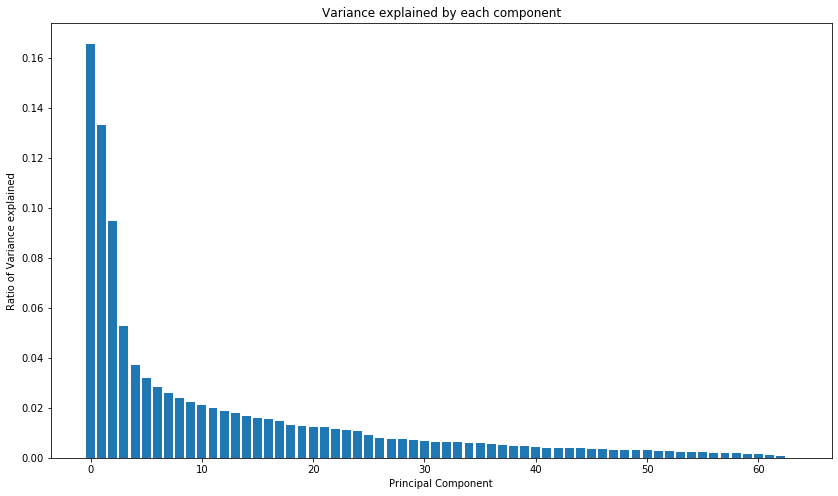

In [62]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize = (14,8))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal Component")
plt.ylabel("Ratio of Variance explained")
plt.show()

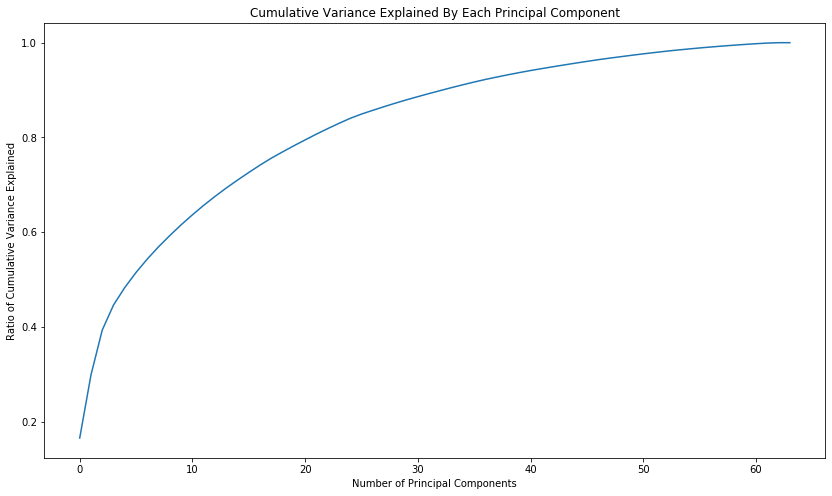

In [63]:
#plotting cummulative variance
plt.figure(figsize = (14,8))
plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), '-')
plt.title('Cumulative Variance Explained By Each Principal Component')
plt.xlabel('Number of Principal Components')
plt.ylabel('Ratio of Cumulative Variance Explained')
line = plt.gca().lines[0]
plt.show()

In [64]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 40)
azdias_pca= pca.fit_transform(azdias_clean)

In [65]:
#vieweing total explained variance
explained_variance_ratio = pca.explained_variance_ratio_
print("\nTotal Explained Variance:", sum(explained_variance_ratio))


Total Explained Variance: 0.936816914021


In [66]:
#confirming columns in azdias_pca
num_components = azdias_pca.shape[1]
print("Number of columns in azdias_pca:", num_components)

Number of columns in azdias_pca: 40


### Discussion 2.2: Perform Dimensionality Reduction

 Dimensionality reduction is about gaining the most knowledge and value from the data in our analysis, reducing the noise, and improving the performance of the model. 
 
The variance per component and cumulative variance graphs above indicate that using about 40 principal components would capture a large majority of the variance in our dataset. By examining the total explained variance ratio, I can see that using 40 components accomplishes an explained variance of about 94%, which is really good. This choice is sufficient to uncover the main patterns in the data during PCA analysis, and adding any more would probably not be added value added to our analysis.






### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [67]:
#creating a function to identify and rank variables based on PCA
def pca_weights_map(data, pca, i):
    weights_map = {}
    for n, feature in enumerate(data.columns):
        weights_map[feature] = round(pca.components_[i][n],4)
        pc_num = i + 1
    weights_df = pd.DataFrame(sorted(weights_map.items(), key=operator.itemgetter(1), reverse=True), columns = ['Feature', 'Weight'])
    weights_df['PC_Number'] = pc_num
    return weights_df

In [68]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc1_weights = pca_weights_map(azdias_clean,pca,0)
print(pc1_weights)

                  Feature  Weight  PC_Number
0              PLZ8_ANTG3  0.2253          1
1              PLZ8_ANTG4  0.2169          1
2                  WEALTH  0.2047          1
3      HH_EINKOMMEN_SCORE  0.2023          1
4             ORTSGR_KLS9  0.1968          1
5                EWDICHTE  0.1947          1
6        FINANZ_HAUSBAUER  0.1596          1
7             KBA05_ANTG4  0.1540          1
8              PLZ8_ANTG2  0.1537          1
9           FINANZ_SPARER  0.1530          1
10                 ARBEIT  0.1426          1
11            KBA05_ANTG3  0.1367          1
12    ANZ_HAUSHALTE_AKTIV  0.1361          1
13               RELAT_AB  0.1350          1
14          SEMIO_PFLICHT  0.1211          1
15              SEMIO_REL  0.1185          1
16                 DECADE  0.1122          1
17               MOVEMENT  0.1102          1
18              SEMIO_RAT  0.0995          1
19            SEMIO_TRADV  0.0936          1
20              SEMIO_MAT  0.0824          1
21  FINANZ

In [69]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc2_weights = pca_weights_map(azdias_clean,pca,1)
print(pc2_weights)

                  Feature  Weight  PC_Number
0    ALTERSKATEGORIE_GROB  0.2563          2
1               SEMIO_ERL  0.2299          2
2        FINANZ_VORSORGER  0.2293          2
3              SEMIO_LUST  0.1802          2
4          RETOURTYP_BK_S  0.1620          2
5        FINANZ_HAUSBAUER  0.1217          2
6              SEMIO_KRIT  0.1180          2
7              SEMIO_KAEM  0.1164          2
8          W_KEIT_KIND_HH  0.1148          2
9              PLZ8_ANTG3  0.0983          2
10               EWDICHTE  0.0978          2
11            ORTSGR_KLS9  0.0965          2
12             PLZ8_ANTG4  0.0961          2
13              ANREDE_KZ  0.0932          2
14                 WEALTH  0.0792          2
15            KBA05_ANTG4  0.0751          2
16              SEMIO_DOM  0.0745          2
17                 ARBEIT  0.0717          2
18               RELAT_AB  0.0692          2
19             PLZ8_ANTG2  0.0681          2
20    ANZ_HAUSHALTE_AKTIV  0.0664          2
21     HH_

In [70]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc3_weights = pca_weights_map(azdias_clean,pca,2)
print(pc3_weights)

                  Feature  Weight  PC_Number
0              SEMIO_VERT  0.3447          3
1               SEMIO_SOZ  0.2619          3
2               SEMIO_FAM  0.2489          3
3              SEMIO_KULT  0.2338          3
4       FINANZ_MINIMALIST  0.1545          3
5          RETOURTYP_BK_S  0.1091          3
6        FINANZ_VORSORGER  0.1018          3
7          W_KEIT_KIND_HH  0.0852          3
8    ALTERSKATEGORIE_GROB  0.0798          3
9               SEMIO_REL  0.0678          3
10             SEMIO_LUST  0.0646          3
11              SEMIO_MAT  0.0556          3
12            ORTSGR_KLS9  0.0503          3
13               EWDICHTE  0.0495          3
14             PLZ8_ANTG4  0.0491          3
15             PLZ8_ANTG3  0.0484          3
16       GREEN_AVANTGARDE  0.0471          3
17                 ARBEIT  0.0373          3
18               RELAT_AB  0.0343          3
19             PLZ8_ANTG2  0.0327          3
20         WOHNDAUER_2008  0.0326          3
21        

In [71]:
#printing first and last 2 weights of top 3 components
print('Top 2:\n{}\n\nBottom 2:\n{}'.format(pc1_weights.head(2), pc1_weights.tail(2)))
print("----------------------------------------------------------------")
print('Top 2:\n     {}\nBottom 2:\n{}'.format(pc2_weights.head(2), pc2_weights.tail(2)))
print("----------------------------------------------------------------")
print('Top 2:\n     {}\nBottom 2:\n{}'.format(pc3_weights.head(2), pc3_weights.tail(2)))
print("----------------------------------------------------------------")

Top 2:
      Feature  Weight  PC_Number
0  PLZ8_ANTG3  0.2253          1
1  PLZ8_ANTG4  0.2169          1

Bottom 2:
       Feature  Weight  PC_Number
62  MOBI_REGIO -0.2249          1
63  PLZ8_ANTG1 -0.2256          1
----------------------------------------------------------------
Top 2:
                     Feature  Weight  PC_Number
0  ALTERSKATEGORIE_GROB  0.2563          2
1             SEMIO_ERL  0.2299          2
Bottom 2:
      Feature  Weight  PC_Number
62     DECADE -0.2386          2
63  SEMIO_REL -0.2537          2
----------------------------------------------------------------
Top 2:
           Feature  Weight  PC_Number
0  SEMIO_VERT  0.3447          3
1   SEMIO_SOZ  0.2619          3
Bottom 2:
       Feature  Weight  PC_Number
62  SEMIO_KAEM -0.3351          3
63   ANREDE_KZ -0.3673          3
----------------------------------------------------------------


In [72]:
#plotting pca to visualize the positive and negative correlations
def plot_pca(data, pca, i):
    pcs = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[i]
    pcs.sort_values(ascending=False, inplace=True)
    pcs = pd.concat([pcs.head(5), pcs.tail(5)])
    pcs.plot(kind = 'bar', title = 'PC ' + str(i+1))
    ax = plt.gca()
    ax.axhline(y=0, color='cyan', linewidth=2)
    ax.grid(linewidth='0.5', alpha=0.5 )
    ax.set_axisbelow(True)
    plt.show()

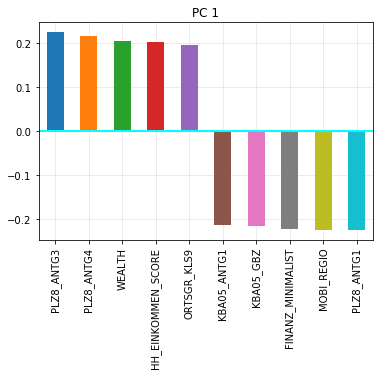

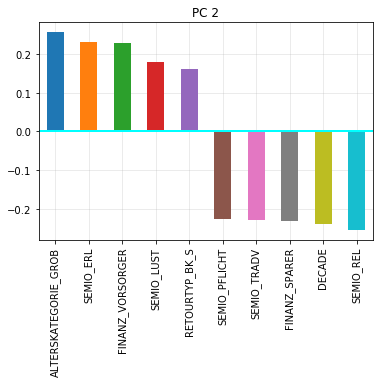

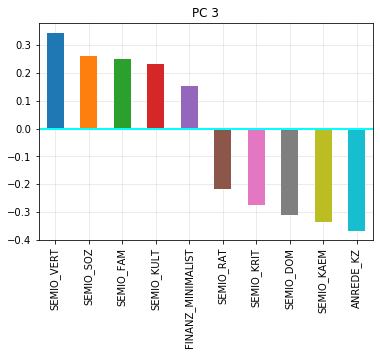

In [73]:
#plotting P1, P2, and PC3 (top 5 components)
plot_pca(azdias_clean,pca,0)
plot_pca(azdias_clean,pca,1)
plot_pca(azdias_clean,pca,2);

### Discussion 2.3: Interpret Principal Components

PC1 represents the most important variation in the dataset.  The top 2 features associated with PC1 suggest that areas with a higher number of larger family houses tend to exhibit similar demographic characteristics and patterns. The bottom 2 features have a negative association with PC1, implying that areas with higher moving patterns and a greater proportion of smaller family homes may indicate significanly different lifestyles and availability of resources.  These areas might have less stability because of a more transient population, unlike the areas with larger family homes that are a sign of stability and longevity.

PC2 is interesting because age and personalities are at opposite ends of the spectrum.  The top end of PC2 is influenced most by an event-oriented group with similaritiesin priorities and personalty traits. The individuals in this demographic subset probably enjoy participating in community events, social gatherings, and other forms of entertainment. On the opposite end, there is a negative association between PC2 and the group of individuals who demonstrate patterns of religous and/or mainstream priorities. 

PC3 is the third most valuable component in this dataset, and suggests that people with dreamful personalities and socially-minded characteristics have a high influence in this component. On the other hand, gender and people with a combative attitude have a negative association with PC3. The data for these two groups is heading in exact opposite directions.

Overall it seems that the important demographic group for this dataset generally exhibits characteristics of happiness, wealth, and friendliness. Features like larger family homes and opportunities to prioritize and attend social events appear to contribute or be related to a more positive personality and outlook. The demographic group whos weight values are negative seems to exhibit less social, and even combative personality characteristics. Frequent moving, along with the pressure of having less rtrying to conform to mainstream norms and religious practices contribute to a lifestyle and priorities that do not contribute value to goals of this analysis.




| Feature Name              | Description                                                  |
| :----------------------- | :----------------------------------------------------------- |
| **PRINCIPAL COMPONENT 1** |                      |
| **(+)Top 2 Values (-)Bottom 2 Values** |
| PC1(+) PLZ8_ANTG3        | Number of 6-10 family houses in the PLZ8 region              |
| PC1(+) PLZ8_ANTG4        | Number of 10+ family houses in the PLZ8 region               |
| PC1(-) MOBI_REGIO        | Moving Patterns                                              |
| PC1(-) PLZ8_ANTG1        | Number of 1-2 family houses in the PLZ8 region               |
| **PRINCIPAL COMPONENT 2** |                                                               |
| PC2(+) ALTERSKATEGORIE_GROB | Estimated age based on given name analysis                 |
| PC2(+) SEMIO_ERL          | Personality type: Event oriented                            |
| PC2(-) SEMIO ERL;DECADE   | Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west) |
| PC2(-) SEMIO_REL          | Personality type: Religious                                 |
| **PRINCIPAL COMPONENT 3** |                                                               |
| PC3(+) SEMIO_VERT         | Personality type: Dreamful                                  |
| PC3(+) SEMIO_SOZ          | Personality type: Socially-minded                           |
| PC3(-) SEMIO_KAEM         | Personality type: Combative attitude                        |
| PC3(-)ANREDE_KZ           | Gender                                                        |


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [74]:
#creating a sample of the dataset; Workspace was timing out
#consistently when using the full dataset
azdias_sample = azdias_clean.sample(frac=0.15, random_state = 47)
azdias_sample.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
65804,0.200589,0.958071,-0.76869,-0.481928,0.411731,-0.570799,-1.184467,-0.792034,1.884775,1.010368,...,0.441766,1.455006,1.485029,-1.173369,-0.127145,-1.526103,-0.267356,-1.884775,0.493932,0.094845
661309,0.200589,0.958071,-0.04277,-1.155304,1.137960,0.108283,-1.184467,1.338816,-0.530567,-0.311674,...,0.441766,-0.616697,-0.337337,0.830164,-0.562417,-0.052205,-0.950300,0.530567,1.175734,-1.249157
315955,0.200589,0.958071,-0.04277,0.864824,-1.040726,0.108283,1.674391,-0.792034,-0.530567,1.010368,...,0.441766,0.419154,-0.337337,-1.173369,-0.127145,-0.052205,1.098531,0.530567,0.493932,0.094845
449735,1.184051,-1.043765,0.68315,-1.155304,1.137960,-1.249881,-0.469752,0.628533,1.884775,-1.633717,...,0.441766,0.419154,-0.337337,0.830164,1.613942,0.684744,-1.633243,-1.884775,-0.187871,0.766845
734764,1.184051,0.958071,0.68315,-1.155304,1.137960,0.108283,-1.184467,0.628533,-0.530567,-0.311674,...,0.441766,0.419154,-0.337337,0.830164,-0.127145,0.684744,-0.950300,0.530567,-1.551476,0.766845


In [75]:
%%time
data = azdias_clean
scores = []
centers = list(range(1,10))
def get_kmeans_score(data,center):
    kmeans = KMeans(n_clusters = center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data)) #absolute value
    return score
for center in centers:
    scores.append(get_kmeans_score(data,center))#scree plot    
print('KMeans scores complete.')

KMeans scores complete.
Wall time: 9min 24s


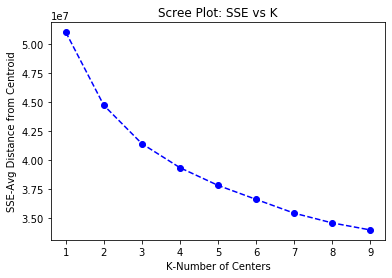

In [76]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers,scores,linestyle='--', marker = 'o', color = 'b');
plt.xlabel('K-Number of Centers');
plt.ylabel('SSE-Avg Distance from Centroid'); #SSE Sumof Squared Estimate
plt.title('Scree Plot: SSE vs K');

In [77]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

#re-fit, predict and print cluster predictions
n_clusters = 7
model= KMeans(n_clusters = n_clusters, random_state = 150)
azdias_preds = model.fit_predict(azdias_pca)
print('Cluster predictions complete. ')    

Cluster predictions complete. 


### Discussion 3.1: Apply Clustering to General Population

I used the KMeans class from the scikit-learn library to perform k-means clustering on my data after applying PCA transformation. To evaluate the quality of the clustering, I used the .score() method, which calculates the average difference between each data point and the center of its assigned cluster. I began by clustering with 10 clusters so that I could find the point at which adding additional points does not benefit the analysis.

After reviewing the scree chart, I decided to proceed with 7 clusters for my analysis, as it appeared to be the point of the "elbow" where adding more clusters would not provide much more insight.

I was then able to obtain cluster predictions which will help me find the patterns and groups within the population that share similar characteristics. 


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [78]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [79]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


#### Preprocessing

In [80]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#Preprocessing by calling clean_data function 
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
customers_clean = clean_data(customers)

Executing function "clean_data"
AZDIAS_Feature_Summary loaded as 'feat_info'
2,252,274 missing values convered to NaN
3,112,918 missing values remain in dataset after conversion.
------------------------------------------------------------------------

Summary of Missing Data in Columns:

Number of columns missing data:      61 (71.76%)
Number of columns not missing data:  24 (28.24%)
Total number of columns:             85 (100%)
------------------------------------------------------------------------

The following outlier columns were dropped:

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
------------------------------------------------------------------------

Summary of Missing Data in Rows:

Starting row count :            191,652
Rows removed (>20 missing):     50,012
New row count (<=20 missing)    141,640
------------------------------------------------------------------------

There are 13 multi-level features in this dataset.

CJT_GESAM

In [81]:
#Number of values missing after conversion
#recalculating n_azdias_null 
customers_null = customers_clean.isnull().sum().sum()
print('Number of values missing after conversion:{:,}'.format(customers_null))

Number of values missing after conversion:102,893


#### FEATURE TRANSFORMATION

In [82]:
#Implementing Imputer function to eliminate missing values
customers_imputed = pd.DataFrame(imputer.transform(customers_clean))

In [83]:
#confirming there are no more missing values   
print('Values missing after imputer function : {}'.format(customers_imputed.isnull().sum().sum()))

Values missing after imputer function : 0


In [84]:
# Apply feature scaling to the general population demographics data.
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed)) 

#### DIMENSIONALITY REDUCTION

In [85]:
#Applying PCA 
customers_pca= pd.DataFrame(pca.transform(customers_scaled))

In [86]:
#customers predictions
customers_pred = model.predict(customers_pca)
print('Cluster predictions complete.')    

Cluster predictions complete.


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

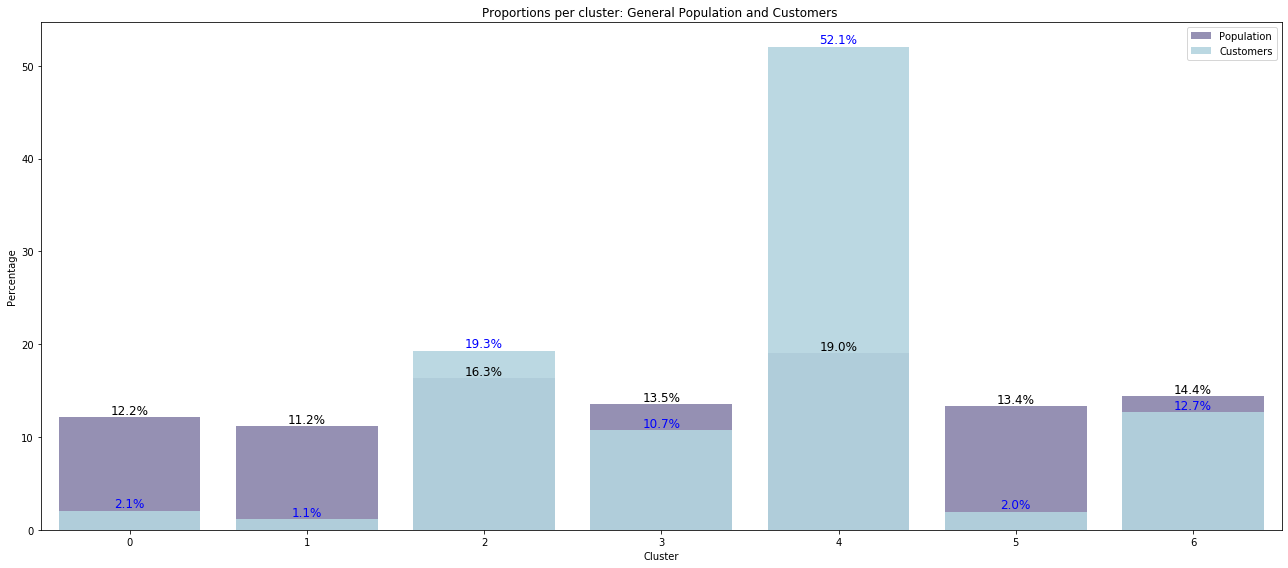

In [93]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
clusters_azdias = pd.DataFrame(pd.Series(azdias_preds).value_counts().sort_index(), columns=['population'])
clusters_azdias['population_%'] = clusters_azdias['population'] / clusters_azdias['population'].sum() * 100
clusters_azdias['customers'] = pd.DataFrame(pd.Series(customers_pred).value_counts().sort_index())
clusters_azdias['customers_%'] = clusters_azdias['customers'] / clusters_azdias['customers'].sum() * 100

fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data=clusters_azdias, x=clusters_azdias.index, y='population_%', color='darkslateblue', label='Population', alpha=0.6, ax=ax)
sns.barplot(data=clusters_azdias, x=clusters_azdias.index, y='customers_%', color='lightblue', label='Customers', alpha=0.9, ax=ax)
for i in range(len(clusters_azdias)):
    percentage = clusters_azdias.iloc[i]['population_%']
    plt.text(i, percentage, f'{percentage:.1f}%', ha='center', va='bottom', color='black',fontsize = 12 )
for i in range(len(clusters_azdias)):
    percentage = clusters_azdias.iloc[i]['customers_%']
    plt.text(i, percentage, f'{percentage:.1f}%', ha='center', va='bottom', color='blue', fontsize = 12)
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Proportions per cluster: General Population and Customers ')
plt.legend()
plt.tight_layout()
plt.show()

In [95]:
#displaying the values of each cluster
print(clusters_azdias)

   population  population_%  customers  customers_%
0       97093     12.175801       2944     2.078509
1       89407     11.211949       1628     1.149393
2      130234     16.331798      27353    19.311635
3      107891     13.529907      15173    10.712369
4      151708     19.024712      73766    52.079921
5      106490     13.354217       2791     1.970489
6      114603     14.371616      17985    12.697684


In [89]:
#adding the cluster numbers to the customers data
customer_clusters = customers_clean
customer_clusters['cluster'] = customers_pred
customer_clusters.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,cluster
0,4.0,1,5,1,5,1,2,2,1,1.0,...,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0,4
2,4.0,2,5,1,5,1,4,4,1,2.0,...,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0,2


In [90]:
#function to print details for features in a given cluster
def cluster_feats(data, cluster):
    cluster_detail = data[data['cluster'] == cluster]
    return cluster_detail

### Overrepresented Group

In [91]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_5 = cluster_feats(customer_clusters,5)
cluster_5.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,cluster
count,2777.000000,2791.0,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2745.000000,...,2544.000000,2544.000000,2780.000000,2782.000000,2780.000000,2765.000000,2765.000000,2741.000000,2741.000000,2791.0
mean,1.725603,1.0,3.309208,3.497671,2.464350,2.955571,3.697599,2.190254,0.410606,2.067760,...,3.719733,3.429245,3.037770,5.764198,3.146403,5.416998,0.585533,2.970814,2.906603,5.0
std,0.746970,0.0,1.199186,1.092453,1.146946,1.313084,1.248766,1.206906,0.492032,0.747054,...,0.944627,1.044293,0.960732,2.166838,1.339388,0.804789,0.492719,1.356475,1.422716,0.0
min,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,5.0
25%,1.000000,1.0,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,0.000000,2.000000,...,3.000000,3.000000,2.000000,4.000000,2.000000,5.000000,0.000000,2.000000,1.000000,5.0
50%,2.000000,1.0,3.000000,4.000000,2.000000,3.000000,4.000000,2.000000,0.000000,2.000000,...,4.000000,3.000000,3.000000,6.000000,3.000000,6.000000,1.000000,3.000000,3.000000,5.0
75%,2.000000,1.0,4.000000,4.000000,3.000000,4.000000,5.000000,3.000000,1.000000,3.000000,...,5.000000,4.000000,4.000000,8.000000,4.000000,6.000000,1.000000,4.000000,4.000000,5.0
max,4.000000,1.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,5.000000,5.000000,5.000000,9.000000,5.000000,6.000000,1.000000,5.000000,5.000000,5.0


**Overrepresentation**<Br>
Cluster 5 is overrepresented.  
There are 73,653 individuals in this group of customers, and based on the population percentage, we would expect about 19% of the individuals in the customer data to fall within this cluster.  However, the customer data shows that,in reality, about 52% of the individuals represented in the customer data are more likely to be customers. Customer representation is more than 30% greater than expected.

Some of the more significantly present characteristics in this group are described below.

| Variable                  | Description                                              | Characteristics in this Cluster                                      
|---------------------------|----------------------------------------------------------|-------------------------------------------------|
| ALTERSKATEGORIE_GROB      | Estimated age based on given name analysis                  | Mean age is 46-60 years old (middle-aged to older adults)                      |
| ANREDE_KZ                 | Gender                                                   | Population is predominantly male                            |
| FINANZ_MINIMALIST         | Financial attitude: Low Financial Interest                  |Moderate financial attitudes, tendandcies towards reduced debt, frugal spending                     |
| FINANZ_VORSORGE           | Financial attitude: Prepared                             | Lean towards saving, but standard deviation suggests some variaions          |
| GREEN_AVANTGARDE               | Environmental sustainability as part of youth | Majority do not belong to green avant-garde; Not very environmentally consious  |
| ARBEIT               | share of unemployment in community         | Mean is 2.61; Indicates a low to average unemployemnt rate
|WEALTH | Wealth of people in the group | Mean 2.096; On average, wealth is closer to middle range

### Underrepresented Group

In [92]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_4 = cluster_feats(customer_clusters,4)
cluster_4.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,cluster
count,73653.000000,73766.000000,73766.000000,73766.000000,73766.000000,73766.000000,73766.000000,73766.000000,73766.000000,73247.000000,...,72603.000000,72603.000000,73473.000000,73486.000000,73473.000000,73485.00000,73485.000000,73492.000000,73492.000000,73766.0
mean,3.583126,1.000407,4.845173,1.299610,4.672207,1.384418,1.819063,2.072649,0.614118,1.948025,...,3.603322,3.893076,2.618186,4.551738,2.608523,2.78397,0.383534,2.096078,3.565817,4.0
std,0.590714,0.020163,0.427368,0.623685,0.687623,0.780725,0.882787,0.879168,0.486806,0.830263,...,0.938670,0.870257,0.997533,1.962050,1.388392,1.24752,0.486250,1.166778,1.150005,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,1.000000,1.000000,4.0
25%,3.000000,1.000000,5.000000,1.000000,5.000000,1.000000,1.000000,2.000000,0.000000,1.000000,...,3.000000,3.000000,2.000000,3.000000,1.000000,2.00000,0.000000,1.000000,3.000000,4.0
50%,4.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,1.000000,2.000000,...,3.000000,4.000000,3.000000,4.000000,3.000000,3.00000,0.000000,2.000000,4.000000,4.0
75%,4.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,1.000000,3.000000,...,4.000000,5.000000,3.000000,6.000000,3.000000,4.00000,1.000000,3.000000,4.000000,4.0
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,5.000000,5.000000,5.000000,9.000000,5.000000,6.00000,1.000000,5.000000,5.000000,4.0


**Underrepresentation**<Br>
Cluster 4 is underrepresented.  

There are 2,771 individuals in this group. Based on the population percentage, we would expect about 13% of the individuals in the customer data to fall within this cluster.  However, the customer data shows that,in reality, only about 2% of the individuals represented in the customer data are likely to be customers for mail order sales. That is a huge difference than what was projected. 

Some of the more significantly present characteristics in this group are described below.

| Variable                  | Description                                              | Characteristics in this Cluster                                      
|---------------------------|----------------------------------------------------------|-------------------------------------------------|
| ALTERSKATEGORIE_GROB      | Estimated age based on given name analysis                  |  Mean age is less than 30 years old                     |
| ANREDE_KZ                 | Gender                                                   | Population is predominantly male                            |
| FINANZ_MINIMALIST         | Financial attitude: Low Financial Interest                  | Prioritize savings, reduced debt, frugal spending                     |
| FINANZ_VORSORGE           | Financial attitude: Prepared                             | Lower tendancy to prioritize, invest and plan for the future          |
| GREEN_AVANTGARDE               | Environmental sustainability as part of youth | Almost half belong to green avant-garde; Environmentally conscious   |
| FINANZ_HAUSBAUER             | Financial attitude: Home ownership| Lower inclination towards home ownership |
| ARBEIT               | share of unemployment in community         | Mean is 3.04; Indicates a low unemployment rate

### Discussion 3.3: Compare Customer Data to Demographics Data

**Summary** 

In summary,it would appear that whatever marketing strategies are being used with the population in Cluster 5 are highly effective. On the contrary, perhaps individuals in Cluster 4 have not been targetted for marketing, or maybe the services or products are not as appealing to individuals in Cluster 4. Some of the differences like age and avant-garde practices may also be affecting their mail order activities. Of course, we cannot discount the possiblity of error or bias in our data collecting and processing, but with the amount of cleaning, transforming, and analyzing we have done here, the results are probably safe assumptions

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.